# Ringdown fit from IMR results

We will show how to initialize a ringdown fit starting from a reference set of inspiral-merger-ringdown (IMR) parameter estimation (PE) samples, as would be produced in a regular GW analysis. This can be useful when launching a first exploratory fit for an event for which we have IMR results for some reference waveform.

<div class="alert alert-info">

Note

The [GWpy package](http://gwpy.github.io/) is only an _optional_ dependence for `ringdown`: you should install it before running this notebook (e.g., `pip install gwpy`); alternatively, you can download the data separately and load it directly from disk as in the GW150914 example.

</div>

In [1]:
!pip install gwpy

## Preliminaries

We begin with some standard imports and global settings.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# disable numpy multithreading to avoid conflicts
# with jax multiprocessing in numpyro
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

# import numpyro and set it up to use 4 CPU devices
import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

# we will use matplotlib, arviz and seaborn for some of the plotting
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

# disable some warning shown by importing LALSuite from a notebook
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# import ringdown package
import ringdown as rd

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

We will make use of a number of external data products in this example.

In [ ]:
!wget -nc https://zenodo.org/records/8115310/files/GW150914_095045_NRSur7dq4.h5
!wget -nc https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW150914_PSDs.dat
!wget -nc https://zenodo.org/records/13376190/files/NRSur7dq4.h5
!wget -nc https://dcc-llo.ligo.org/public/0161/T1900393/003/NRSur7dq4Remnant.h5

We will turn on logging to see details:

In [3]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [4]:
psds_o1 = np.loadtxt('GWTC1_GW150914_PSDs.dat')

psds_o1 ={
    'H1': rd.PowerSpectrum(psds_o1[:,1], index=psds_o1[:,0], ifo='H1'),
    'L1': rd.PowerSpectrum(psds_o1[:,2], index=psds_o1[:,0], ifo='L1')
}

INFO:root:completing power spectrum to next power of two
INFO:root:completing power spectrum to next power of two


In [7]:
# from importlib import reload
# reload(rd.fit)
# reload(rd.fit.imr)

In [23]:
fit = rd.fit.Fit.from_imr_result('GW150914_095045_NRSur7dq4.h5', psds=psds_o1, modes=[(1,-2,2,2,0), (1, -2,2,2,1)],
                                 peak_kws=dict(manual=True, nsamp=100))

INFO:root:completing low frequencies with 10x max PSD
INFO:root:completing low frequencies with 10x max PSD
INFO:root:missing local data for H1: /anvil/projects/x-phy990007n/vvarma/Work/Projects/Current/NRSurCatalog/runs/GWTC/Data/GW150914_095045/H1_data.gwf
INFO:root:fetching 4.0 s long segment centered on 1126259462.391 [1126259460.391, 1126259464.391]
INFO:root:fetching open data from GWOSC
INFO:root:fetching 4.0 s long segment centered on 1126259462.391 [1126259460.391, 1126259464.391]
INFO:root:fetching open data from GWOSC
INFO:root:completing power spectrum to next power of two
INFO:root:completing power spectrum to next power of two


waveforms:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:caching waveforms
INFO:root:estimated duration: 0.2578125


peak time:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:setting target: SkyTarget(geocenter_time=LIGOTimeGPS(1126259462, 410903931), ra=1.2882574310526138, dec=-1.2508181709183033, psi=2.3471961334882856, duration=0.2578125)
INFO:root:completing power spectrum to next power of two
INFO:root:completing power spectrum to next power of two
INFO:root:using cached waveforms
INFO:root:estimating mass prior
INFO:root:quantiles [0.0050000000000000044, 0.5, 0.995]: 63.16077316601783, 67.22847210028883, 72.11265355541224


In [24]:
fit.target

SkyTarget(geocenter_time=LIGOTimeGPS(1126259462, 410903931), ra=1.2882574310526138, dec=-1.2508181709183033, psi=2.3471961334882856, duration=0.2578125)

In [7]:
snrs = fit.compute_imr_snr(cumulative=True, nsamp=100)

waveforms:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:wiping waveform cache


In [18]:
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=0.2)

INFO:root:unused keyword arguments: {'ifos': ['H1', 'L1']}


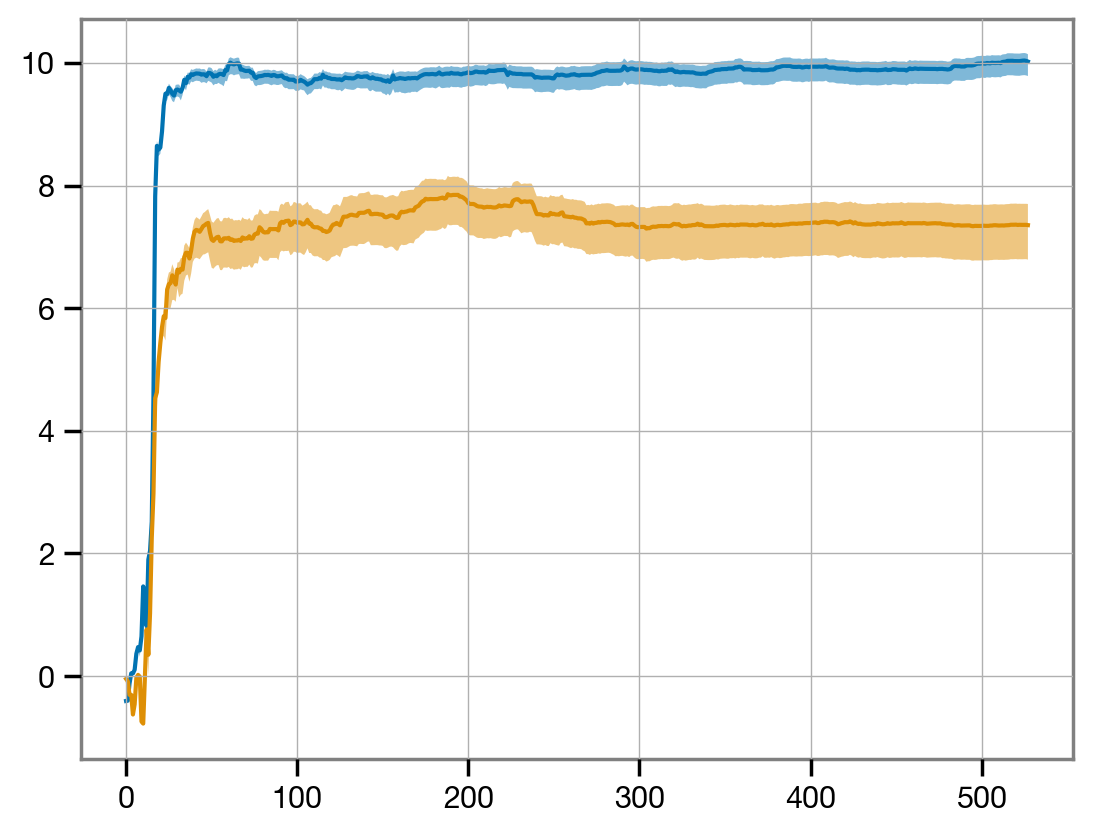

In [8]:
for s in snrs:
    l, m, h = np.quantile(s, [0.05, 0.5, 0.95], axis=1)
    plt.plot(m)
    plt.fill_between(np.arange(len(m)), l, h, alpha=0.5)

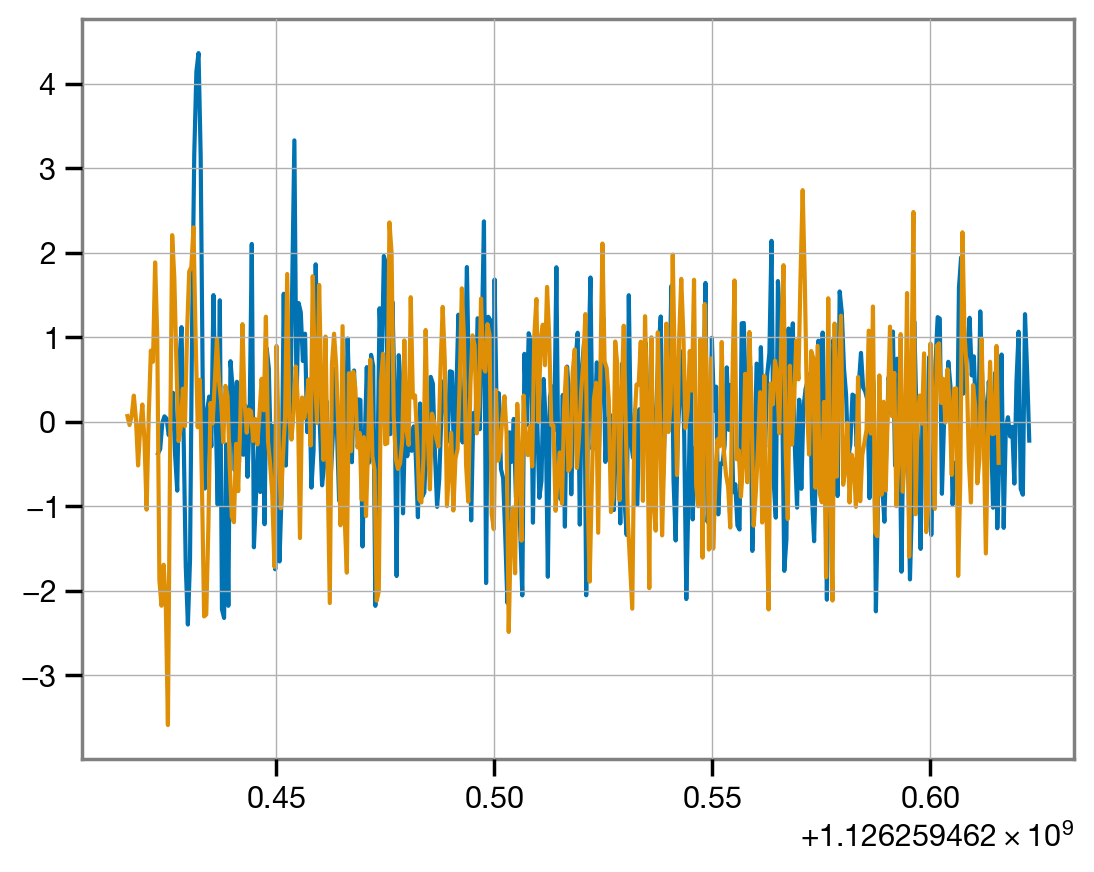

In [19]:
for i, d in fit.whitened_analysis_data.items():
    d.plot()

In [35]:
bpt = fit.imr_result.get_best_peak_times(nsamp=100)[0]

/opt/miniconda3/envs/ringdown-jax/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/ringdown-jax/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/miniconda3/envs/ringdown-jax/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/miniconda3/envs/ringdown-jax/lib/python3.12

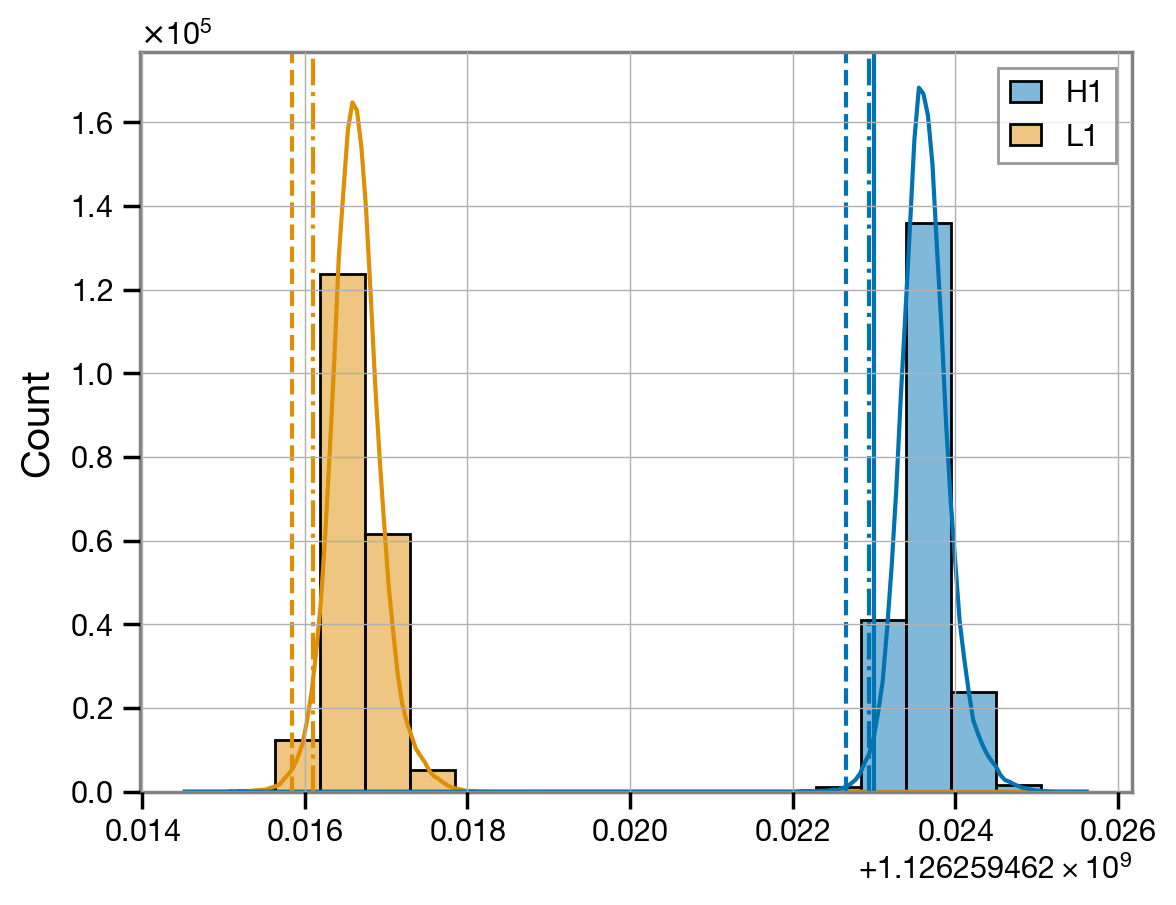

In [36]:
peak_times = fit.imr_result.get_peak_times()
sns.histplot(peak_times, bins=20, kde=True)
plt.axvline(1126259462.423)
plt.axvline(fit.start_times['H1'], ls='--')
plt.axvline(fit.start_times['L1'], ls='--', c='C1')
plt.axvline(bpt['H1'], ls='-.')
plt.axvline(bpt['L1'], ls='-.', c='C1')

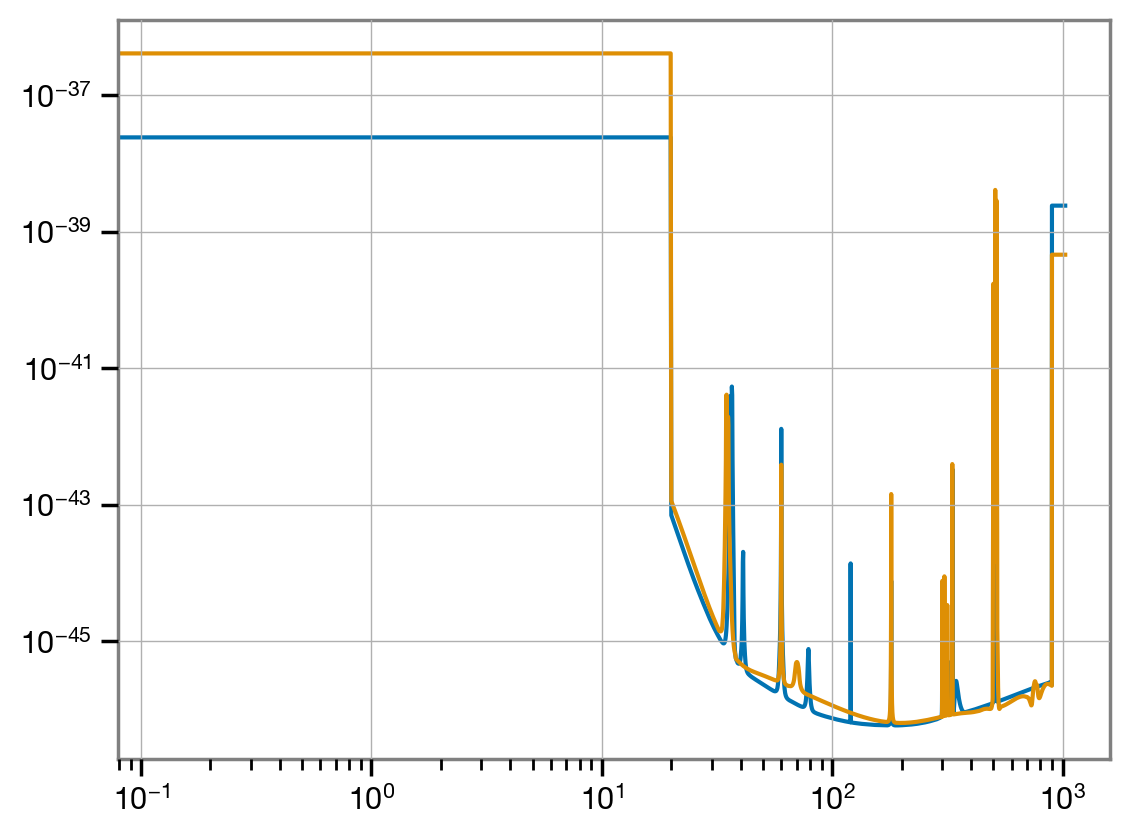

In [26]:
for ifo, acf in fit.acfs.items():
    p = acf.to_psd()
    plt.loglog(p)

In [28]:
fit.model_settings

{'a_scale_max': 5.954091087051518e-20, 'm_max': 117.0, 'm_min': 33.0}

In [29]:
fit.run()

INFO:root:making model
INFO:root:running [(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)] mode fit
INFO:root:prior run: False
INFO:root:model settings: {'a_scale_max': 5.954091087051518e-20, 'm_max': 117.0, 'm_min': 33.0}
INFO:root:kernel settings: {'dense_mass': True}
INFO:root:sampler settings: {'num_warmup': 1000, 'num_samples': 1000, 'num_chains': 4}
INFO:root:run settings: {}
INFO:root:running on 4 CPU using 1 OMP threads
INFO:root:rescaled strain by 1.0


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:added strain to observed data
INFO:root:ess = 1259 after 1 runs
INFO:root:obtaining predictive distribution
INFO:root:added a to posterior
INFO:root:added acx to posterior
INFO:root:added acx_unit to posterior
INFO:root:added acy to posterior
INFO:root:added acy_unit to posterior
INFO:root:added apx to posterior
INFO:root:added apx_unit to posterior
INFO:root:added apy to posterior
INFO:root:added apy_unit to posterior
INFO:root:added ellip to posterior
INFO:root:added h_det_mode to posterior
INFO:root:added phi to posterior
INFO:root:added phi_l to posterior
INFO:root:added phi_r to posterior
INFO:root:added theta to posterior
INFO:root:rescaling strain by 1.0


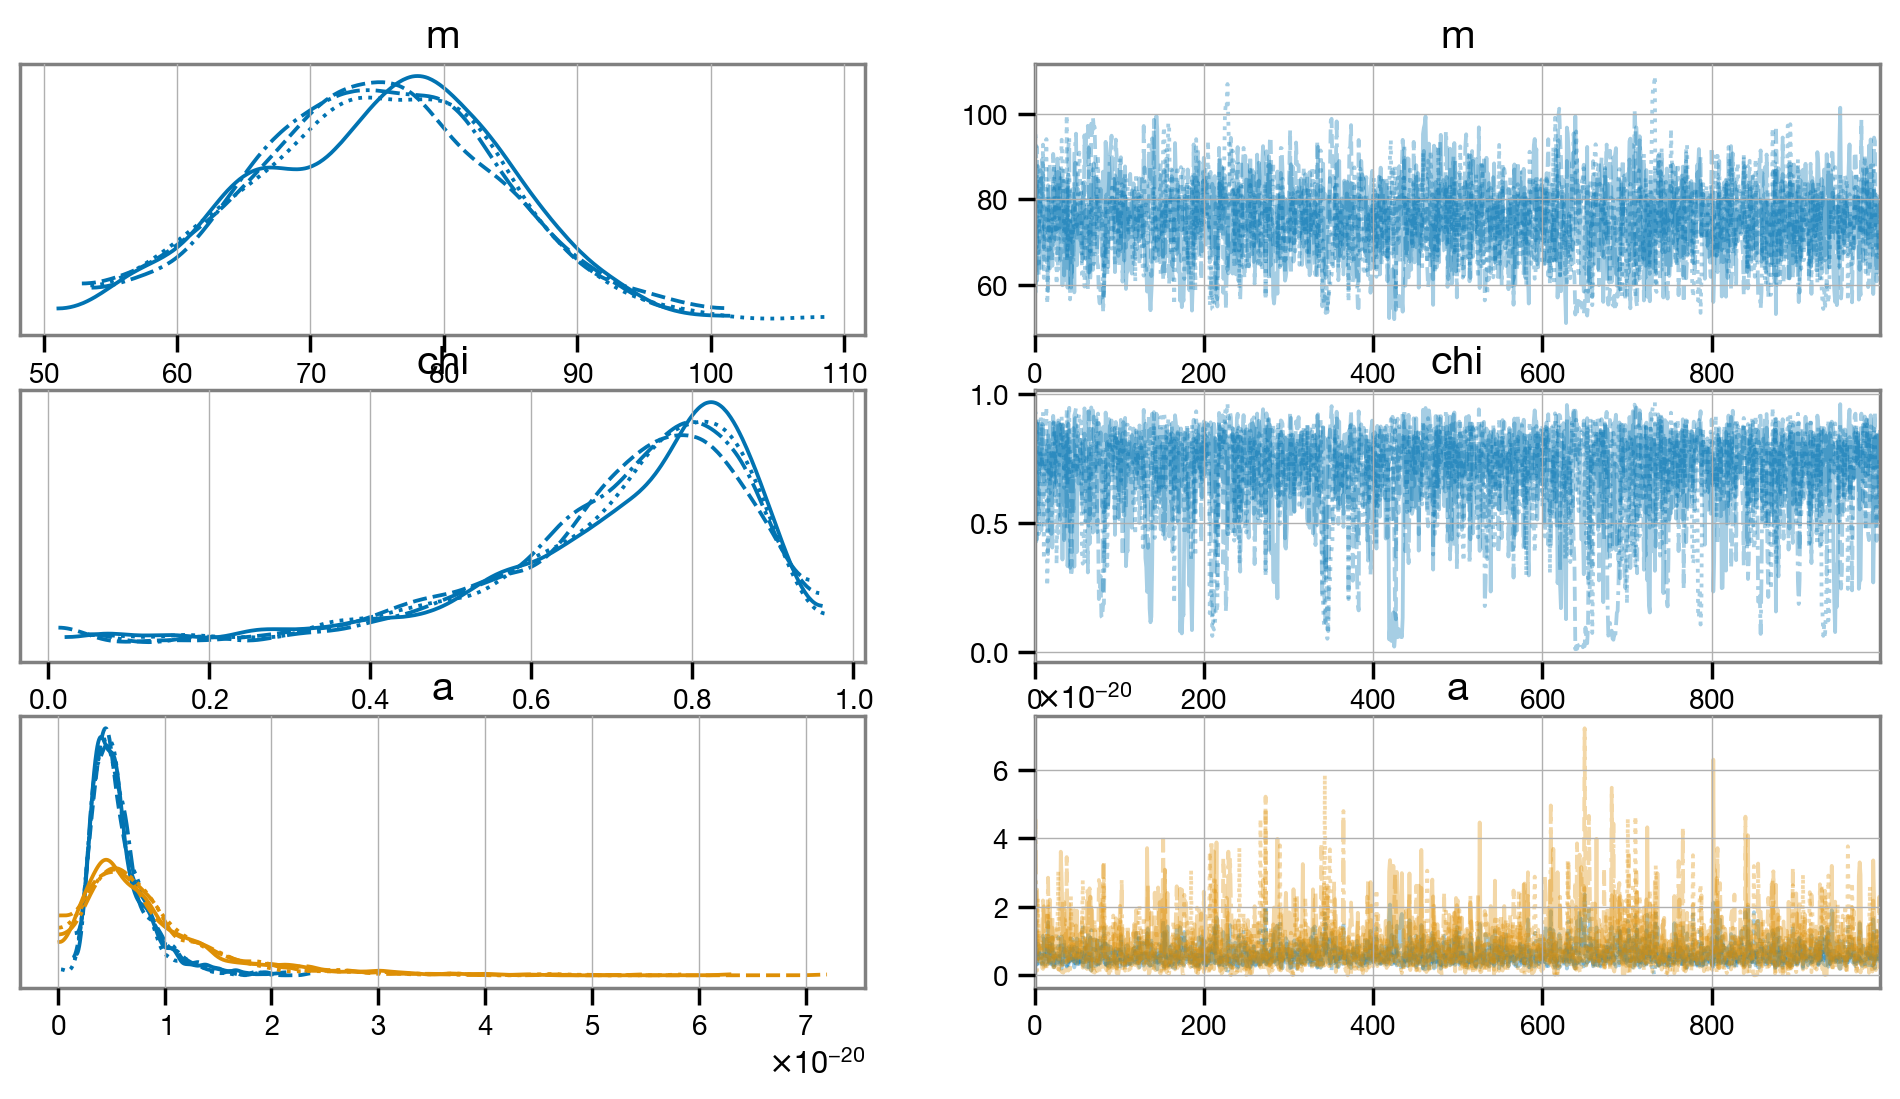

In [31]:
az.plot_trace(fit.result, var_names=['m', 'chi', 'a']);

In [10]:
result.config['detectors']

['H1', 'L1']

In [23]:
result.head()

,luminosity_distance,mass_ratio,chirp_mass,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,theta_jn,psi,phase,azimuth,zenith,geocent_time,log_likelihood,ra,dec,H1_matched_filter_snr,H1_optimal_snr,L1_matched_filter_snr,L1_optimal_snr,maximum_frequency,pn_spin_order,pn_tidal_order,pn_phase_order,pn_amplitude_order,total_mass,mass_1,mass_2,symmetric_mass_ratio,phi_1,phi_2,chi_eff,chi_1_in_plane,chi_2_in_plane,chi_p,cos_tilt_1,cos_tilt_2,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,H1_matched_filter_abs_snr,H1_matched_filter_snr_angle,L1_matched_filter_abs_snr,L1_matched_filter_snr_angle,redshift,inverted_mass_ratio,iota,spin_1x,spin_1y,spin_1z,spin_2x,spin_2y,spin_2z,chi_p_2spin,beta,psi_J,H1_time,L1_time,network_optimal_snr,network_matched_filter_snr,cos_theta_jn,viewing_angle,cos_iota,final_mass,final_spin,final_kick,final_spin_x,final_spin_y,final_spin_z,final_kick_x,final_kick_y,final_kick_z
0,302.826828,0.734899,29.459787,0.229117,0.989102,1.708336,1.999300,5.902614,4.534809,2.468383,2.468992,5.801904,3.450437,2.316410,1.126259e+09,314.969185,0.855911,-0.974286,20.746185,18.693582,14.842469,15.363897,896.0,-1.0,-1.0,-1.0,0.0,68.647077,39.568340,29.078737,0.244163,2.042515,1.661944,-0.192198,0.226953,0.899676,0.632922,-0.137106,-0.415511,284.282094,37.145224,27.297991,27.655707,64.443216,20.960187,-0.143020,14.939764,0.114189,0.065233,1.360731,2.715441,-0.103132,0.202167,-0.031413,-0.081889,0.895941,-0.410982,0.914816,0.253035,4.146974,1.126259e+09,1.126259e+09,24.197093,25.451762,-0.781825,0.673209,-0.910563,65.699611,0.655320,71.995865,-0.048552,0.164005,0.632605,-2.400312,-43.084701,-57.631168
1,246.782208,0.779489,31.673929,0.021743,0.001494,2.568186,0.234519,4.210718,4.765504,0.947162,2.152491,1.433344,3.663922,2.454467,1.126259e+09,315.976558,1.013275,-0.799393,20.827590,18.574147,14.945288,16.312193,896.0,-1.0,-1.0,-1.0,0.0,73.446365,41.273849,32.172516,0.246161,0.206238,4.416956,-0.009628,0.011796,0.000347,0.011796,-0.840058,0.972626,234.228083,39.174196,30.535859,30.062636,69.710055,20.827701,0.003261,14.968575,0.055787,0.053598,1.282892,0.950961,0.011546,0.002416,-0.018266,-0.000101,-0.000332,0.001453,0.011693,0.003804,3.723040,1.126259e+09,1.126259e+09,24.720166,25.511364,0.583989,0.947162,0.580902,70.014383,0.674577,68.487263,0.002461,0.000299,0.674572,-59.993215,-28.806539,-16.171044
2,651.643545,0.904419,31.977017,0.482512,0.450922,1.306195,1.244835,2.684418,3.655800,0.394299,1.852646,0.839206,2.091525,2.424010,1.126259e+09,316.477744,2.551772,-0.914572,20.779898,19.994867,14.987861,11.058679,896.0,-1.0,-1.0,-1.0,0.0,73.575150,38.633916,34.941234,0.249370,5.275824,1.677056,0.134834,0.465719,0.427178,0.465719,0.261524,0.320220,574.593566,34.065863,30.809801,28.196072,64.875664,20.813142,-0.056528,14.988295,0.007612,0.134095,1.105683,0.424801,0.248738,-0.393731,0.126189,-0.045307,0.424768,0.144394,0.160572,0.056508,3.543042,1.126259e+09,1.126259e+09,22.849269,25.437892,0.923266,0.394299,0.911121,69.742052,0.724297,514.776666,0.038608,-0.008782,0.723214,41.521575,-26.492069,512.415013
3,263.168901,0.765861,29.002934,0.290240,0.417444,1.647053,2.186473,2.793536,5.210874,2.440947,2.303888,2.804800,3.672881,2.348173,1.126259e+09,316.855970,0.860429,-0.810382,20.956456,18.822856,14.980380,17.643957,896.0,-1.0,-1.0,-1.0,0.0,67.344133,38.136707,29.207426,0.245605,4.981127,1.491478,-0.117078,0.289397,0.340794,0.289397,-0.076182,-0.577511,248.972827,36.079506,27.631895,27.438434,63.711401,20.957714,0.010956,14.981196,-0.010441,0.057018,1.305720,2.477153,0.076839,-0.279009,-0.022111,0.027003,0.339723,-0.241079,0.101897,0.041503,3.842509,1.126259e+09,1.126259e+09,25.799401,25.534450,-0.764426,0.700646,-0.787262,64.346354,0.645933,421.435161,0.012262,-0.020363,0.645496,-7.911054,-33.576324,420.021000
4,369.591443,0.924252,31.471865,0.063842,0.118751,2.307212,2.796207,3.196202,0.259453,2.810778,1.690424,3.376205,3.307935,2.337180,1.126259e+09,317.142720,0.960116,-1.064914,20.876791,20.732829,14.675436

In [24]:
[k for k,v in result.attrs['config'].items() if 'data' in k]

['data-dump',
 'data-dict',
 'data-dump-file',
 'data-format',
 'ignore-gwpy-data-quality-check',
 'plot-data']

In [11]:
nrsur_result.print_configs()

Tmax:                               10000
accounting:                         None
accounting_user:                    None
adapt:                              False
allow_tape:                         True
analysis_executable:                None
analysis_executable_parser:         None
autocorr_c:                         5.0
autocorr_tol:                       50.0
bilby_zero_likelihood_mode:         False
burn_in_nact:                       50.0
calibration_model:                  CubicSpline
calibration_prior_boundary:         reflective
catch_waveform_errors:              True
channel_dict:                       {H1:DCS-CALIB_STRAIN_C02, L1:DCS-CALIB_STRAIN_C02}
check_point_deltaT:                 3600
clean:                              False
coherence_test:                     False
conda_env:                          None
condor_job_priority:                0
conversion_function:                None
create_summary:                     True
data_dict:                          {H

In [23]:
c = rd.utils.load_config('../../etc/ringdown_fit_config_example.ini')

In [26]:
c.has_option('data', 'path')# and c['imr'].get('option', False)

True

In [26]:
# f = h5py.File(".nrsur_catalog_cache/GW150914_095045_NRSur7dq4.h5", "r")

In [30]:
# rd.utils.get_hdf5_value(f['Bilby:NRSur7dq4']['meta_data']['other']['config_file']['detectors'][()])

'H1'

In [12]:
dd = result.config['data-dict']
chars_to_remove = "'{}"
translation_table = str.maketrans('', '', chars_to_remove)
{k.translate(translation_table): v for k, v in [i.split(':') for i in dd.split(',')]}

{'H1': '/anvil/projects/x-phy990007n/vvarma/Work/Projects/Current/NRSurCatalog/runs/GWTC/Data/GW150914_095045/H1_data.gwf',
 ' L1': '/anvil/projects/x-phy990007n/vvarma/Work/Projects/Current/NRSurCatalog/runs/GWTC/Data/GW150914_095045/L1_data.gwf}'}

In [13]:
result.config['channel-dict']

'{H1:DCS-CALIB_STRAIN_C02, L1:DCS-CALIB_STRAIN_C02}'

In [14]:
result.data_options

INFO:root:missing local data for H1: /anvil/projects/x-phy990007n/vvarma/Work/Projects/Current/NRSurCatalog/runs/GWTC/Data/GW150914_095045/H1_data.gwf


{'t0': 1126259462.391,
 'ifos': 'H1',
 'seglen': 4.0,
 'sample_rate': 16384,
 'channel': 'gwosc'}

In [13]:
result.minimum_frequency

{'H1': 20.0, ' L1': 20.0, ' waveform': 0.0}

In [16]:
# wfs = result.get_waveforms(500, model='NRSur7dq4', f_ref=20, fast_projection=False)

In [9]:
# from pesummary.gw.fetch import fetch_open_samples
# fetch_open_samples("GW200224_222234", unpack=False, read_file=False, delete_on_exit=False, outdir="./", verbose=True)

In [10]:
# from pesummary.io import read

In [11]:
# pe = read("IGWN-GWTC3p0-v1-GW200224_222234_PEDataRelease_mixed_cosmo.h5")

In [14]:
group = 'C01:IMRPhenomXPHM'
# {i: rd.PowerSpectrum(p[:,1], index=p[:,0]) for i, p in f[group]['psds'].items()}

In [15]:
import os
os.environ["LAL_DATA_PATH"] = os.getcwd()

In [16]:
import ringdown as rd
from importlib import reload
reload(rd.imr)
reload(rd.data)
reload(rd.fit)
reload(rd.fit.imr)

<module 'ringdown.imr' from '/Users/maxisi/src/ringdown/ringdown/imr.py'>

In [17]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [18]:
r = rd.imr.IMRResult.from_pesummary('IGWN-GWTC3p0-v1-GW200224_222234_PEDataRelease_mixed_cosmo.h5', pesummary_read=False, group='C01:IMRPhenomXPHM')

INFO:root:completing power spectrum to next power of two
INFO:root:no need to complete low PSD frequencies
INFO:root:completing power spectrum to next power of two
INFO:root:no need to complete low PSD frequencies
INFO:root:completing power spectrum to next power of two
INFO:root:no need to complete low PSD frequencies


In [19]:
r.ifos

['H1', 'L1', 'V1']

In [20]:
r.config['minimum-frequency']

{'H1': 20, 'L1': 20, 'V1': 20}

In [17]:
[k for k,v in r.attrs['config'].items() if 'H1' in str(v)]

['channel-dict',
 'detectors',
 'maximum-frequency',
 'minimum-frequency',
 'psd-dict',
 'reference-frame',
 'spline-calibration-envelope-dict']

In [16]:
print(r.attrs['config'])

{'accounting': 'ligo.prod.o3.cbc.pe.lalinference', 'calibration-model': 'CubicSpline', 'catch-waveform-errors': True, 'channel-dict': '{ H1:DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01, L1:DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01,V1:Hrec_hoft_16384Hz }', 'coherence-test': False, 'convert-to-flat-in-component-mass': False, 'create-plots': True, 'create-summary': False, 'data-dict': None, 'data-format': None, 'deltaT': 0.2, 'detectors': ['H1', 'L1', 'V1'], 'distance-marginalization': True, 'distance-marginalization-lookup-table': 'TD.npz', 'duration': 4.0, 'email': None, 'existing-dir': None, 'extra-likelihood-kwargs': None, 'frequency-domain-source-model': 'lal_binary_black_hole', 'gaussian-noise': False, 'generation-seed': None, 'gps-file': None, 'gps-tuple': None, 'ignore-gwpy-data-quality-check': True, 'injection': False, 'injection-dict': None, 'injection-file': None, 'injection-numbers': None, 'injection-waveform-approximant': None, 'jitter-time': True, 'label': 'Prod5', 'likelihood-type': 'Gravit

In [17]:
# f = rd.fit.Fit.from_imr_result(r, cache_data=True)
# f

In [113]:
f.duration

0.044921875

In [106]:
f.info

{'data': {'path': {'H1': None, 'L1': None, 'V1': None},
  'ifos': ['H1', 'L1', 'V1'],
  'channel': 'gwosc',
  'frametype': None,
  'slide': None,
  'cache': False,
  't0': 1266618172.401773,
  'seglen': 4.0,
  'sample_rate': 16384},
 'target': {'t0': None,
  'ra': None,
  'dec': None,
  'psi': None,
  'duration': 0.044921875,
  'reference_ifo': None,
  'antenna_patterns': None,
  'n_analyze': None,
  'target': SkyTarget(geocenter_time=LIGOTimeGPS(1266618172, 378366709), ra=3.0434338953946565, dec=-0.15420307625505503, psi=2.3365644318743675)},
 'condition': {'preserve_acfs': False, 'ds': 16.0}}

In [55]:
f.imr_result

In [56]:
wfs = r.get_waveforms(100)

waveforms:   0%|          | 0/100 [00:00<?, ?it/s]

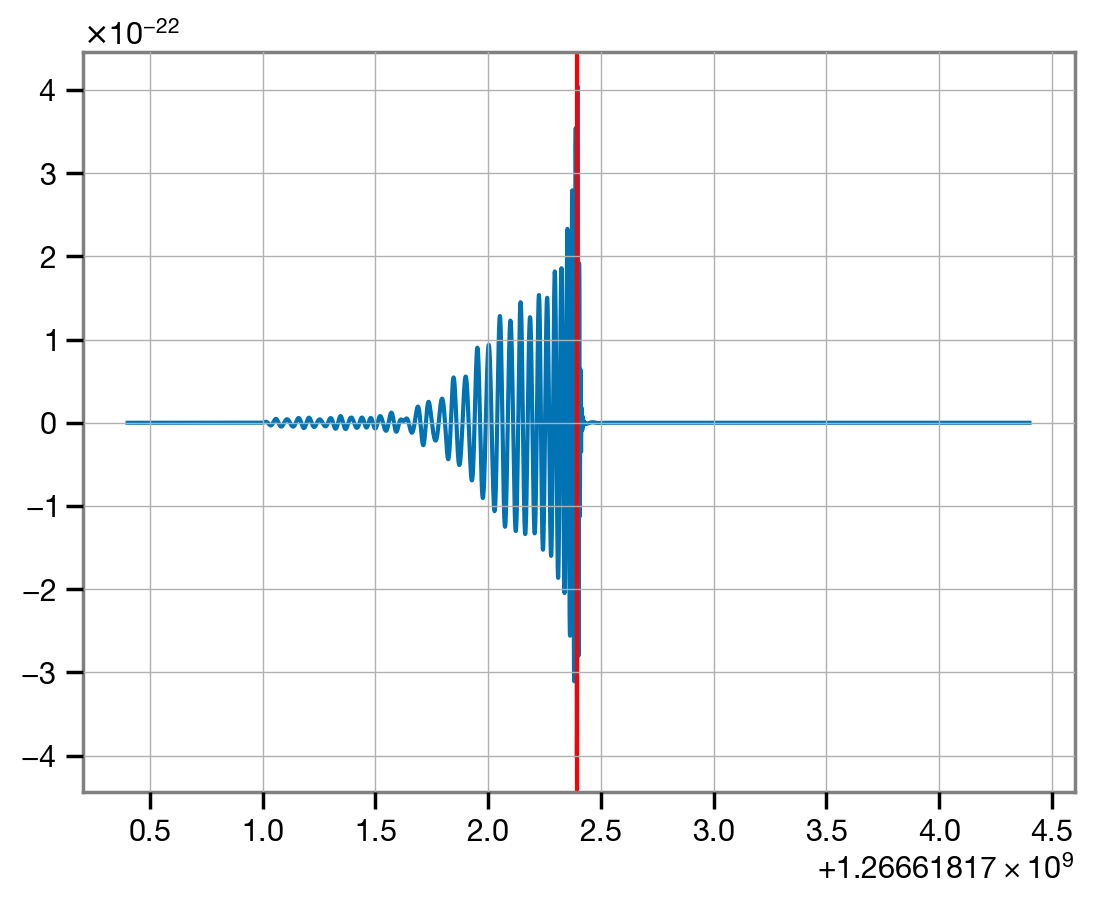

In [61]:
plt.plot(r._get_default_time(), wfs[0,:,0])
plt.axvline(f.start_times['H1'], c='red')

In [63]:
f.cholesky_factors

{'H1': array([[2.65370012e-20, 0.00000000e+00, 0.00000000e+00],
        [4.70382850e-21, 2.61167844e-20, 0.00000000e+00],
        [2.52857917e-20, 2.25352209e-22, 8.04924772e-21]]),
 'L1': array([[2.38125355e-20, 0.00000000e+00, 0.00000000e+00],
        [9.31065870e-21, 2.19168539e-20, 0.00000000e+00],
        [2.29215374e-20, 3.78511428e-22, 6.44179334e-21]]),
 'V1': array([[ 1.06118060e-19,  0.00000000e+00,  0.00000000e+00],
        [-4.57262956e-20,  9.57608927e-20,  0.00000000e+00],
        [ 9.70715099e-20, -4.31977203e-21,  4.26556468e-20]])}

In [85]:
50 * np.median(r['total_mass']) * rd.qnms.T_MSUN * r.sampling_frequency

23.88306412824839

In [75]:
f.add_imr_result(r)

In [109]:
wfsa = f.get_imr_analysis_templates(nsamp=100)

waveforms:   0%|          | 0/100 [00:00<?, ?it/s]

In [110]:
snr = wfsa.compute_snr(f.cholesky_factors, cumulative=True, network=True)
snr

array([[ 0.01761583,  0.01654064,  0.0179899 , ...,
         0.01831243,  0.01751464,  0.0203144 ],
       [ 0.01814323,  0.0167749 ,  0.01851212, ...,
         0.01877318,  0.01795153,  0.02130564],
       [ 0.09311481,  0.10219919,  0.09954258, ...,
         0.10843047,  0.11249934,  0.13475199],
       ...,
       [10.77676243, 10.64420538, 10.1132434 , ...,
        12.6643141 , 11.37686002, 12.9302913 ],
       [10.77984641, 10.64764162, 10.11656445, ...,
        12.66764124, 11.38073153, 12.93461644],
       [10.78112763, 10.64870506, 10.11787099, ...,
        12.66826367, 11.3816967 , 12.93566224]])

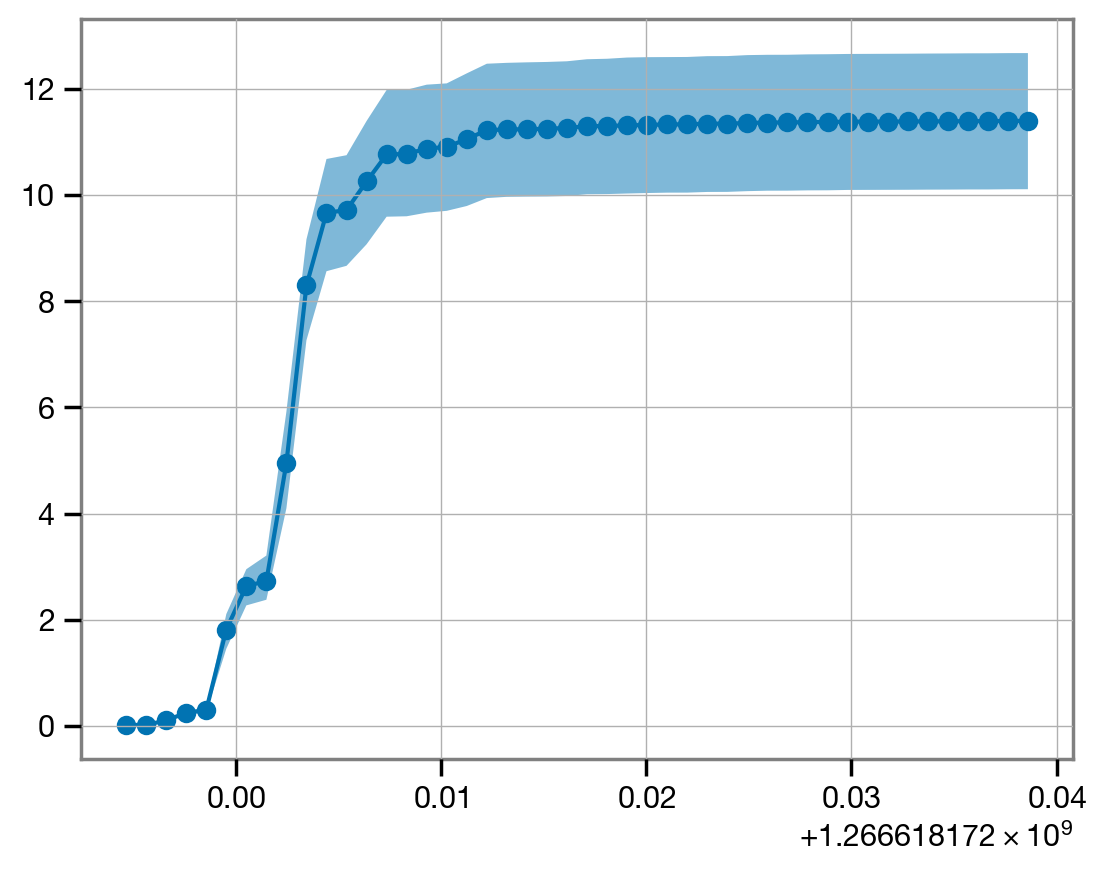

In [111]:
l, m, h = np.quantile(snr, [0.05, 0.5, 0.95], axis=-1)
plt.plot(f.analysis_times['H1'], m, marker='o')
plt.fill_between(f.analysis_times['H1'], l, h, alpha=0.5)

In [115]:
snrs = wfsa.compute_snr(f.cholesky_factors, cumulative=True, network=False)
snr

array([[ 0.01761583,  0.01654064,  0.0179899 , ...,
         0.01831243,  0.01751464,  0.0203144 ],
       [ 0.01814323,  0.0167749 ,  0.01851212, ...,
         0.01877318,  0.01795153,  0.02130564],
       [ 0.09311481,  0.10219919,  0.09954258, ...,
         0.10843047,  0.11249934,  0.13475199],
       ...,
       [10.77676243, 10.64420538, 10.1132434 , ...,
        12.6643141 , 11.37686002, 12.9302913 ],
       [10.77984641, 10.64764162, 10.11656445, ...,
        12.66764124, 11.38073153, 12.93461644],
       [10.78112763, 10.64870506, 10.11787099, ...,
        12.66826367, 11.3816967 , 12.93566224]])

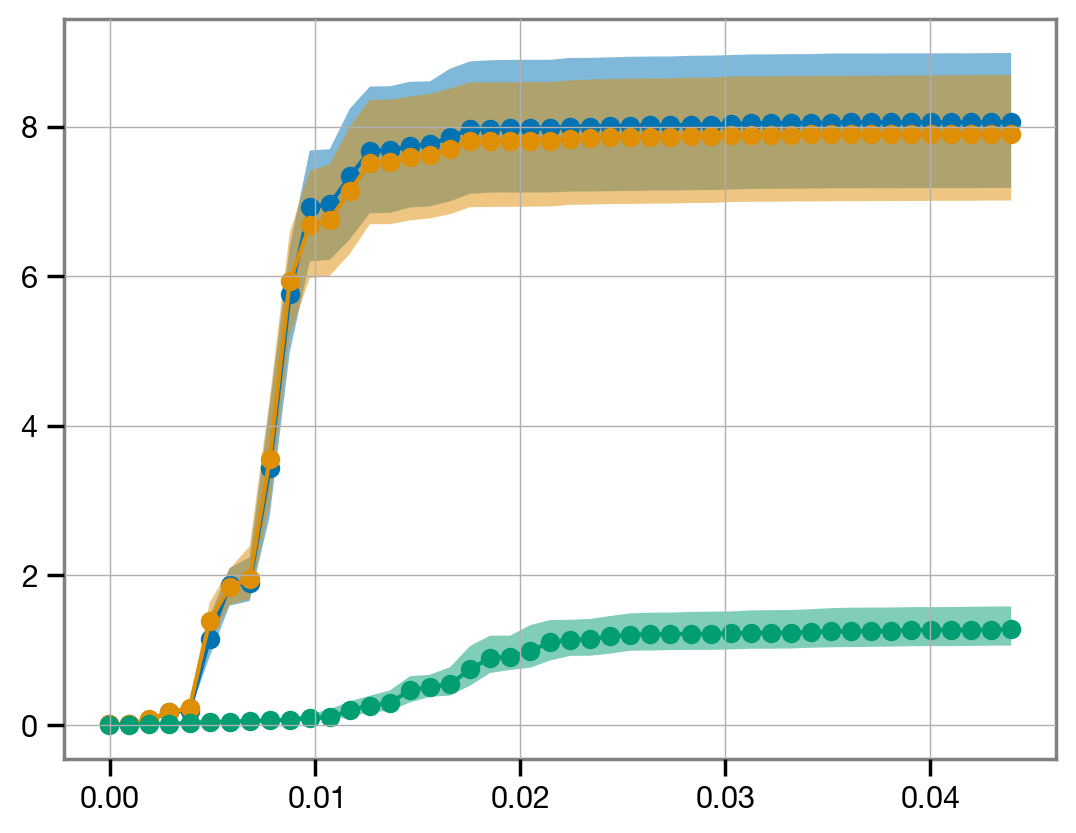

In [117]:
for rho in snrs:
    l, m, h = np.quantile(rho, [0.05, 0.5, 0.95], axis=-1)
    plt.plot(f.analysis_times['H1'] - f.start_times['H1'], m, marker='o')
    plt.fill_between(f.analysis_times['H1'] - f.start_times['H1'], l, h, alpha=0.5)

In [138]:
f.set_modes(1)

In [119]:
f.modes

ModeIndexList(indices=[HarmonicIndex(p=1, s=-2, l=2, m=2, n=0)])

In [141]:
freq = f.imr_result.sample(100).get_kerr_frequencies([(1,-2,2,2,0)])

In [142]:
freq

,f_220,g_220
22805,194.481994,184.704660
10896,197.001256,177.189803
35805,197.314127,169.382651
37916,197.330995,187.362586
14679,197.028950,182.649599
...,...,...
1617,202.629445,190.003708
52442,189.416080,159.823046
24263,196.636758,192.176136
52804,194.625765,176.818757


In [149]:
f.update_model(a_scale_max=5E-22, f_min=50, f_max=300, g_min=50, g_max=300)

In [150]:
f.run()

INFO:root:running 1 mode fit
INFO:root:prior run: False
INFO:root:model settings: {'a_scale_max': 5e-22, 'm_min': 50, 'm_max': 200, 'f_min': 50, 'f_max': 300, 'g_min': 50, 'g_max': 300}
INFO:root:kernel settings: {'dense_mass': True}
INFO:root:sampler settings: {'num_warmup': 1000, 'num_samples': 1000, 'num_chains': 4}
INFO:root:run settings: {}
INFO:root:running on 4 CPU using 1 OMP threads
INFO:root:rescaled strain by 1.0


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:added strain to observed data
INFO:root:ess = 1503 after 1 runs
INFO:root:obtaining predictive distribution
INFO:root:added a to posterior
INFO:root:added acx to posterior
INFO:root:added acx_unit to posterior
INFO:root:added acy to posterior
INFO:root:added acy_unit to posterior
INFO:root:added apx to posterior
INFO:root:added apx_unit to posterior
INFO:root:added apy to posterior
INFO:root:added apy_unit to posterior
INFO:root:added ellip to posterior
INFO:root:added h_det_mode to posterior
INFO:root:added phi to posterior
INFO:root:added phi_l to posterior
INFO:root:added phi_r to posterior
INFO:root:added theta to posterior
INFO:root:rescaling strain by 1.0


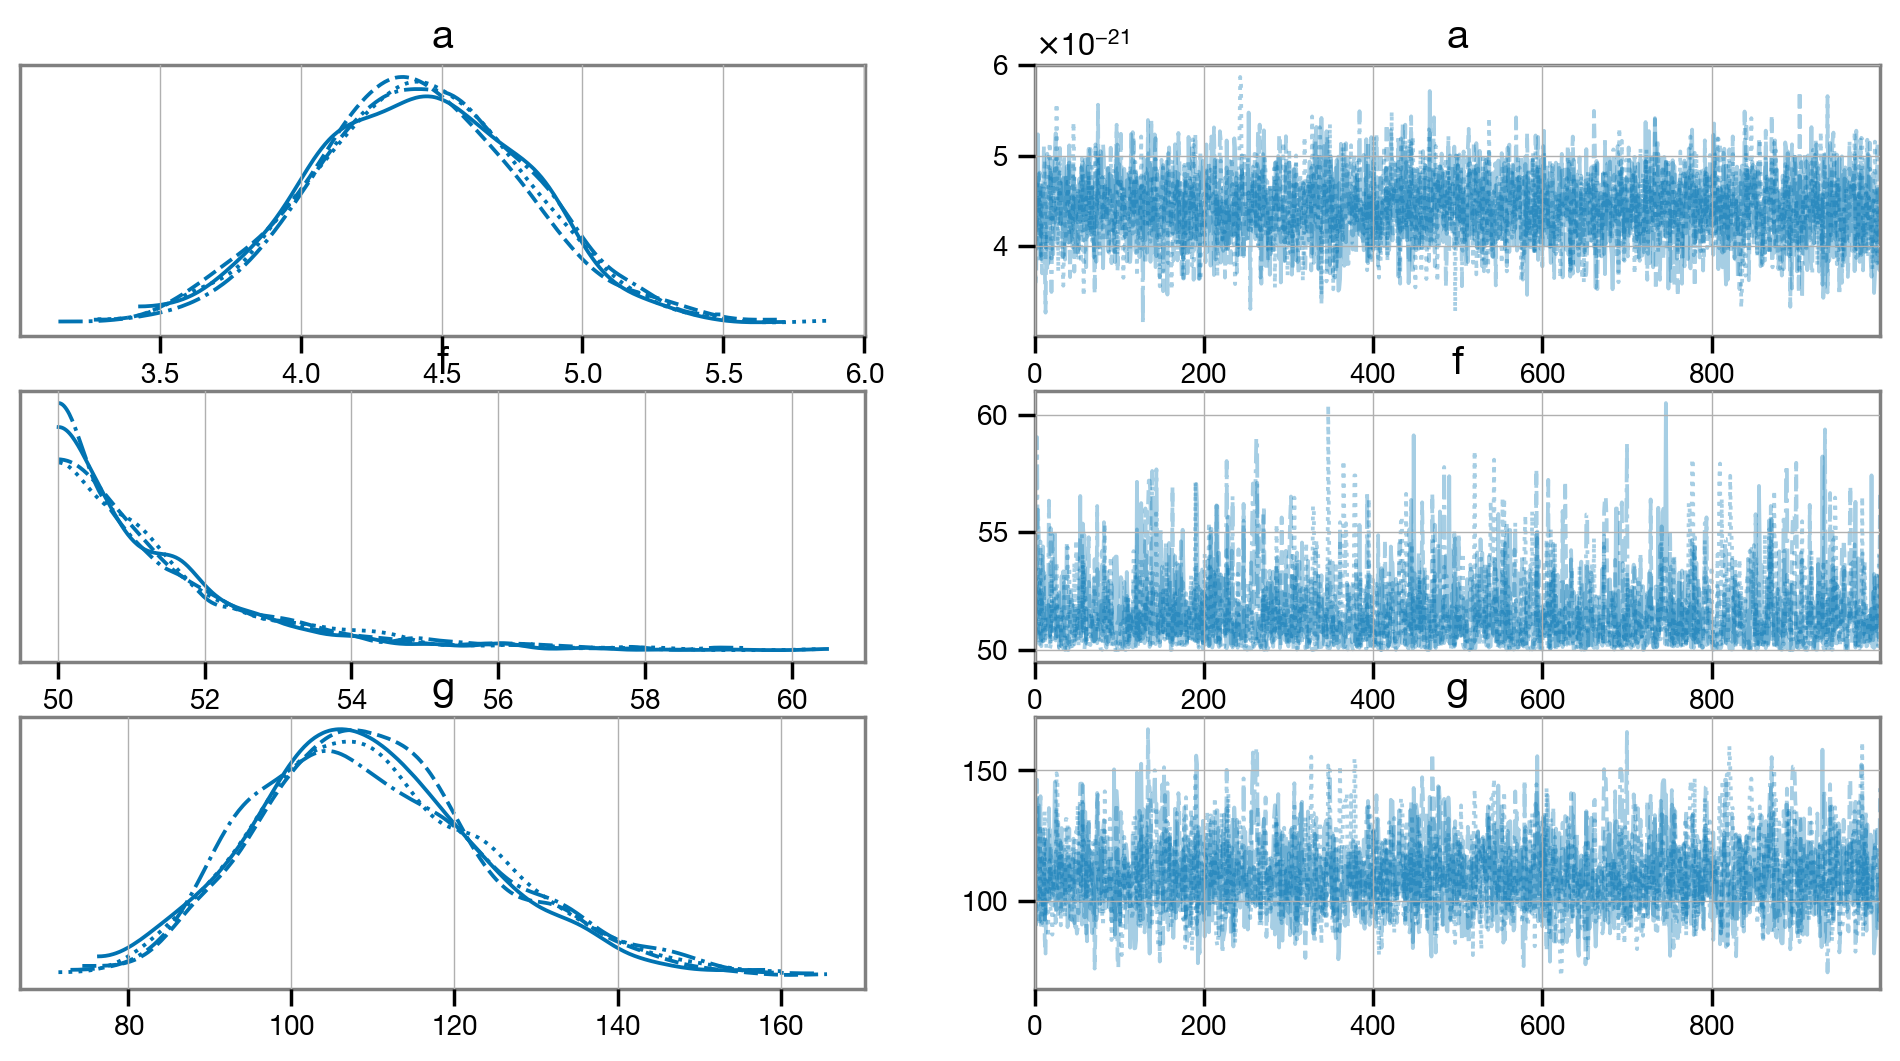

In [151]:
import arviz as az
az.plot_trace(f.result, var_names=['a', 'f', 'g']);

In [152]:
h = f.result.whitened_templates
h.shape

(3, 46, 4000)

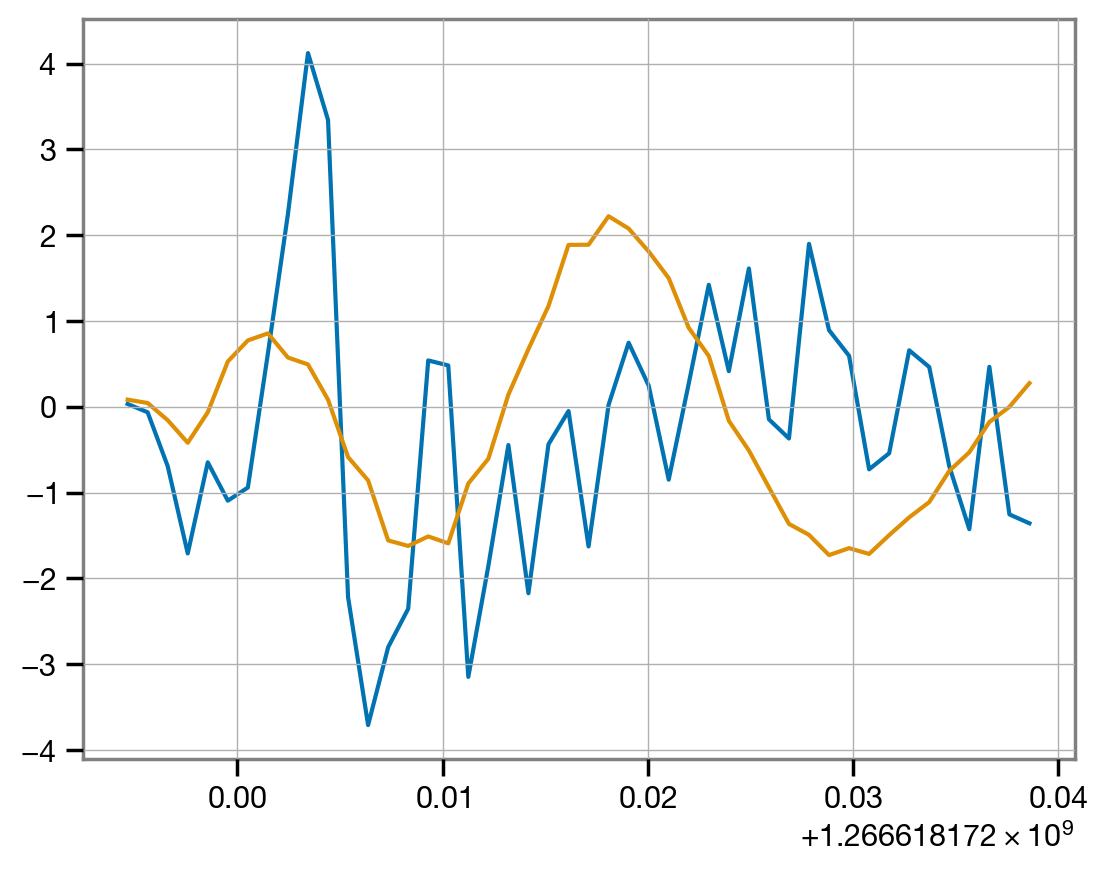

In [153]:
d = f.whiten(f.analysis_data)['H1']
d.plot()
plt.plot(d.time, np.median(h[0,:,:], axis=-1))

In [18]:
r.data_options

{'t0': 1266618172.401773,
 'ifos': ['H1', 'L1', 'V1'],
 'seglen': 4.0,
 'sample_rate': 16384}

In [42]:
snrs, n = estimate_duration(r, q=0.01)

waveforms:   0%|          | 0/100 [00:00<?, ?it/s]

23
46
92
184
368
736
1472


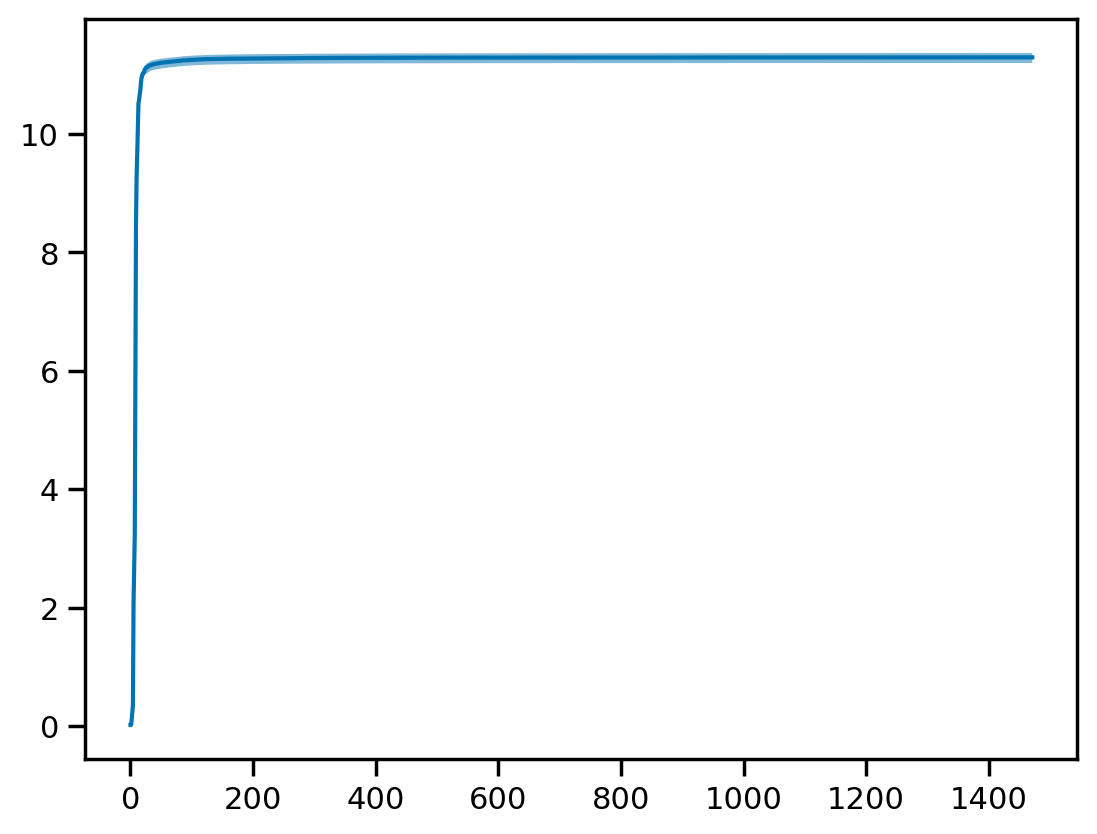

In [43]:
q = 0.1
l, m, h = np.quantile(snrs, [(1-q)/2, 0.5, 1-(1-q)/2], axis=-1)
plt.plot(m)
plt.fill_between(np.arange(len(m)), h, l, alpha=0.5)

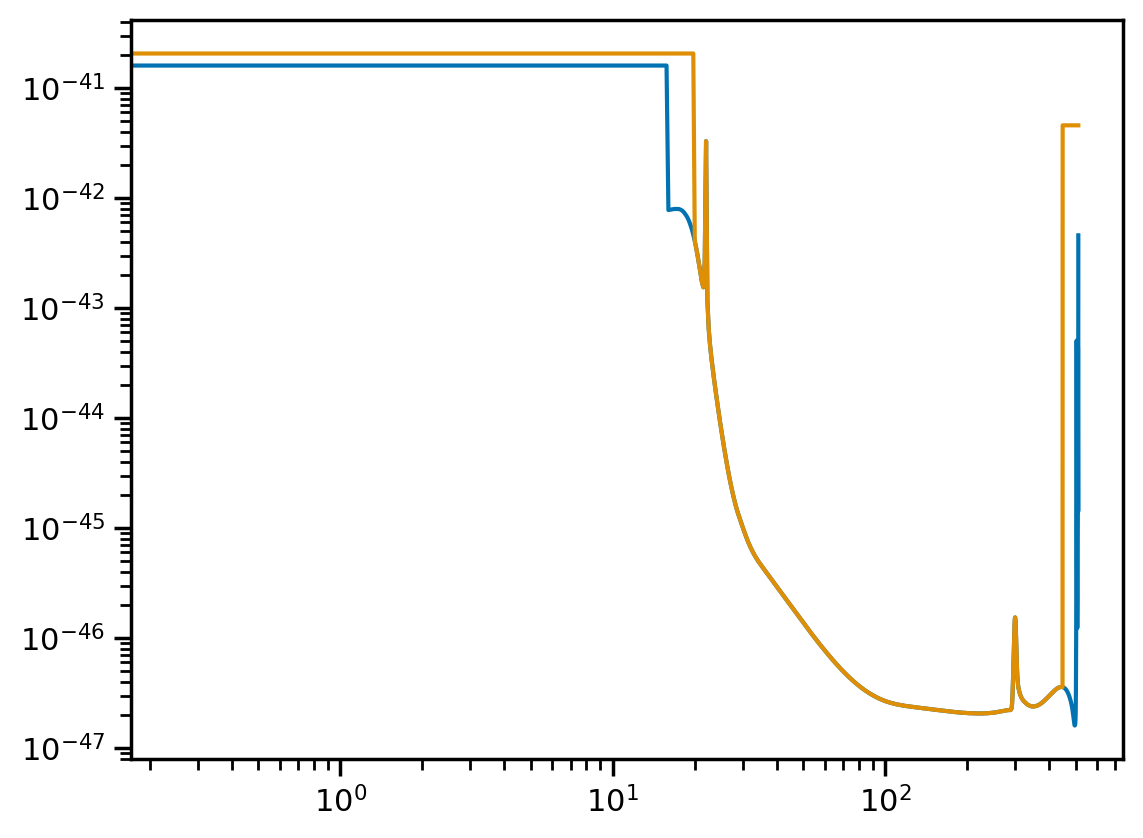

In [21]:
import matplotlib.pyplot as plt
plt.loglog(r.psds['H1'])
plt.loglog(r.get_patched_psds()['H1'])

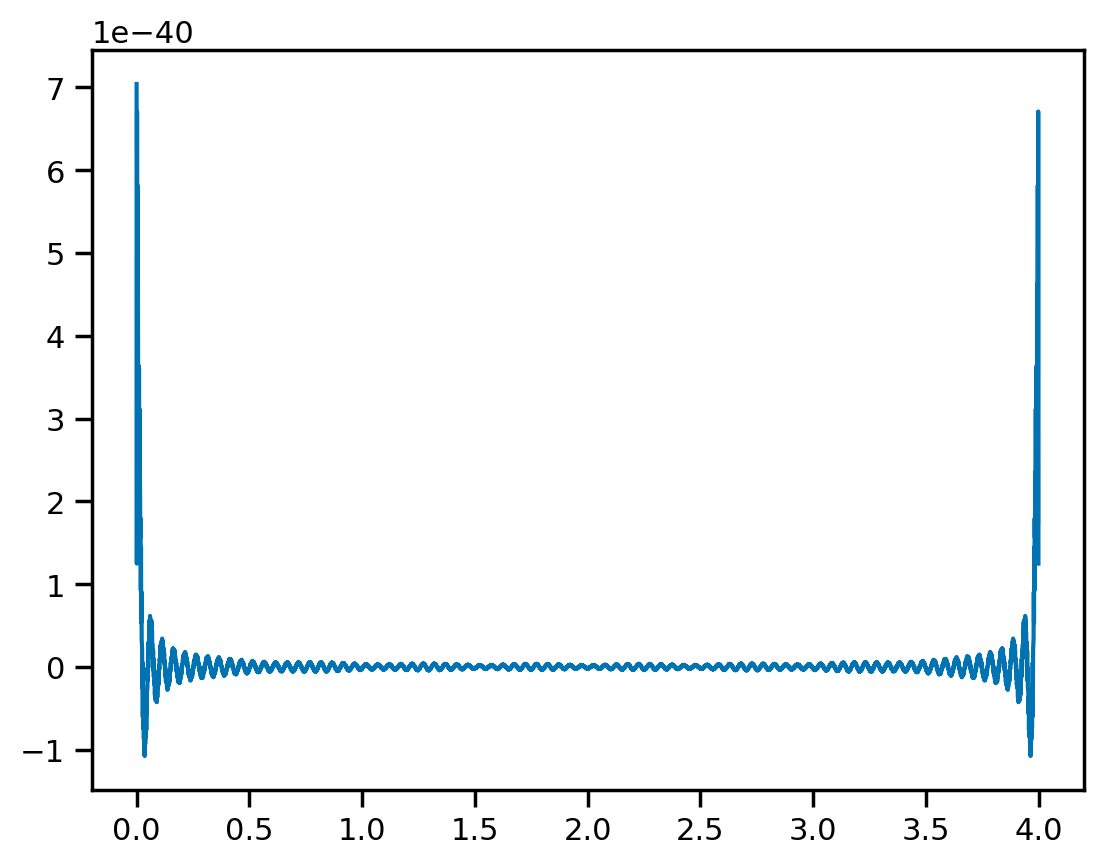

In [22]:
plt.plot(r.get_acfs()['H1'])

In [23]:
def get_value(x):
    return np.array2string(np.array(x))
{k: get_value(v[()]) for k, v in f['C01:IMRPhenomXPHM/config_file/config'].items()}

NameError: name 'f' is not defined